# Quick and Dirty STL Decomposition

This notebook shows you how to make a simple STL decomposition transform that can be used in a forecast pipeline. Internally, we will use statsmodels' `seasonal_decompose` method to compute a trend and seasonal component of a time series.

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore") 

from azuremltkbase.pipeline import FunctionTransformerWrapper
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
matplotlib.use('agg')
%matplotlib inline
from matplotlib import pyplot as plt

from ftk import AzureMLForecastPipeline
from ftk.data import load_dow_jones_dataset
from ftk.transforms import TimeIndexFeaturizer

ModuleNotFoundError: No module named 'azuremltkbase'

## Load Example Data
We load the Dow Jones data and extract the revenue time series for Apple and Microsoft.

In [42]:
train_df, test_df = load_dow_jones_dataset()

grain_list = ['AAPL', 'MSFT']
train_df = train_df[train_df.grain_index.isin(grain_list)]
train_df.groupby_grain().head(2)

,,revenue
quarter_start,company_ticker,
2000-01-01,AAPL,1945.00
2000-04-01,AAPL,1825.00
2000-01-01,MSFT,5656.00
2000-04-01,MSFT,5804.00


Just as an example, we compute and plot the decomposition of the Apple series. The `freq` argument of `seasonal_decompose` refers to the seasonality of the data in the unit of time periods. Since this data is quarterly, we assume a seasonality of 4. The `model` argument can be "additive" or "multiplicative." The latter seems to fit this data better, in our experience.

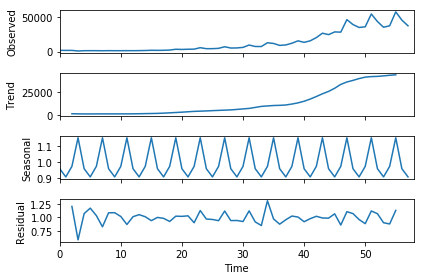

In [23]:
train_one = train_df[train_df.grain_index.isin(['AAPL'])]
series_vals = train_one[train_one.ts_value_colname].values

model_type='multiplicative'
result = seasonal_decompose(series_vals, model=model_type, freq=4)
result.plot()
plt.show()

## Make a Transform Object
Here, we define a function, `stl_func`, that adds trend and seasonal component columns to an input `TimeSeriesDataFrame`. Since a `TimeSeriesDataFrame` can contain multiple time series, we first write a helper function which creates the component columns for a single time series (i.e. a single grain of the data frame). Finally, we create a transform by wrapping `stl_func` with a `FunctionTransformerWrapper`. 

In [43]:
def stl_one_grain(df_one, model_type, seasonality):
    series_vals = df_one[df_one.ts_value_colname].values
    stl_result = seasonal_decompose(series_vals, model=model_type, freq=seasonality)
    
    season_name = df_one.ts_value_colname + '_season'
    trend_name = df_one.ts_value_colname + '_trend'
    
    assign_dict = {season_name: stl_result.seasonal, 
                   trend_name: stl_result.trend}
    return df_one.assign(**assign_dict)

def stl_func(df, model_type='multiplicative', seasonality=4):
    df_stl = (df.groupby_grain()
              .apply(lambda df_one: 
                  stl_one_grain(df_one, model_type, seasonality)))
    return df_stl

stl_transform = FunctionTransformerWrapper(stl_func)

Now we create a pipeline with two transform steps: a time index featurizer that creates time-based features and the STL transform. Running the `fit_transform` method produces a new `TimeSeriesDataFrame` with the desired features. We print the first 4 rows for both series in the data frame.

In [41]:
pline = AzureMLForecastPipeline(
    steps=[('time_index', TimeIndexFeaturizer()),
          ('stl_decomp', stl_transform)])

train_features_df = pline.fit_transform(train_df)
train_features_df.groupby_grain().head(4)

F1 2018-07-03 21:37:29,594 INFO azureml.timeseries - pipeline fit_transform started. 
F1 2018-07-03 21:37:29,742 INFO azureml.timeseries - pipeline fit_transform finished. Time elapsed 0:00:00.147886


,,revenue,year,half,quarter,wday,week,revenue_season,revenue_trend
quarter_start,company_ticker,,,,,,,,
2000-01-01,AAPL,1945.00,2000,1,1,5,52,0.96,nan
2000-04-01,AAPL,1825.00,2000,1,2,5,13,0.91,nan
2000-07-01,AAPL,1870.00,2000,2,3,5,26,0.98,1597.50
2000-10-01,AAPL,1007.00,2000,2,4,6,39,1.15,1489.50
2000-01-01,MSFT,5656.00,2000,1,1,5,52,0.98,nan
2000-04-01,MSFT,5804.00,2000,1,2,5,13,0.98,nan
2000-07-01,MSFT,5766.00,2000,2,3,5,26,0.93,6037.38
2000-10-01,MSFT,6550.00,2000,2,4,6,39,1.11,6227.38
